<h1 ><big><center>Object recognition and computer vision 2019/2020</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 2: Neural networks</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://nicolas.le-roux.name/">Nicolas le Roux</a>, 
  <br><a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> and <a href="https://cs.nyu.edu/~fergus/teaching/vision/">Rob Fergus</a>
  <br> by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Antoine Moulin

**EMAIL**:  antoine.moulin@telecom-paris.fr

# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, ** it is imperative that you do this assignment yourself. No code sharing will be tolerated. **

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A2_LASTNAME_Firstname.ipynb**, and submitted in the **class Moodle page**.

# Goal


The goal of this assignment is to get basic knowledge and hands-on experience with training and using neural networks. In Part 1 of the assignment you will implement and experiment with the training and testing of a simple two layer fully-connected neural network, similar to the one depicted in Figure 1 above. In Part 2 you will learn about convolutional neural networks, their motivation, building blocks, and how they are trained. Finally, in part 3 you will train a CNN for classification using the CIFAR-10 dataset.

# Part 1 - Training a fully connected neural network

## Getting started

You will be working with a two layer neural network of the following form 

\begin{equation}
H=\text{ReLU}(W_i X+B_i)\\
Y=W_oH+B_o
\tag{1}
\end{equation}

where $X$ is the input, $Y$ is the output, $H$ is the hidden layer, and $W_i$, $W_o$, $B_i$ and $B_o$ are the network parameters that need to be trained. Here the subscripts $i$ and $o$ stand for the *input* and *output* layer, respectively. This network was also discussed in the class and is illustrated in the above figure where the input units are shown in green, the hidden units in blue and the output in yellow. This network is implemented in the function `nnet_forward_logloss`.

You will train the parameters of the network from labelled training data $\{X^n,Y^n\}$ where $X^n$ are points in $\mathbb{R}^2$ and $Y^n\in\{-1,1\}$ are labels for each point. You will use the stochastic gradient descent algorithm discussed in the class to minimize the loss of the network on the training data given by 

\begin{equation}
L=\sum_n s(Y^n,\bar{Y}(X^n))
\tag{2}
\end{equation}

where $Y^n$ is the target label for the n-th example and $\bar{Y}(X^n)$ is the network’s output for the n-th example $X^n$. The skeleton of the training procedure is provided in the `train_loop` function. 

We will use the logistic loss, which has the following form:

\begin{equation}
s(Y, \bar{Y}(X))=\log(1+\exp(-Y. \bar{Y}(X))
\tag{3}
\end{equation}

where $Y$ is the target label and $\bar{Y}(X)$ is the output of the network for input example $X$. With the logistic loss, the output of the network can be interpreted as a probability $P(\text{class}=1|X) =\sigma(X)$ , where $\sigma(X) =1/(1+\exp(-X))$ is the sigmoid function. Note also that $P(\text{class}=-1|X)=1-P(\text{class}=1|X)$.

In [0]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio


def decision_boundary_nnet(X, Y, Wi, bi, Wo, bo):
    x_min, x_max = -2, 4
    y_min, y_max = -5, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                     np.arange(y_min, y_max, .05))

    XX = np.vstack((xx.ravel(), yy.ravel())).T
    input_hidden = np.dot(XX, Wi) + bi
    hidden = np.maximum(input_hidden, 0)
    Z = np.dot(hidden, Wo) + bo

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='winter')
    plt.axis([-2, 4, -5, 3])
    plt.draw()


def sigm(x):
    # Returns the sigmoid of x.
    small_x = np.where(x < -20)  # Avoid overflows.
    sigm_x = 1/(1 + np.exp(-x))
    if type(sigm_x) is np.ndarray:
        sigm_x[small_x] = 0.0
    return sigm_x


def nnet_forward_logloss(X, Y, Wi, bi, Wo, bo):
    '''
    Compute the output Po, Yo and the loss of the network for the input X
    This is a 2 layer (1 hidden layer network)

    Input:
        X ... (in R^2) set of input points, one per column
        Y ... {-1,1} the target values for the set of points X
        Wi, bi, Wo, bo ... parameters of the network

    Output: 
       Po ... probabilisitc output of the network P(class=1 | x) 
                  Po is in <0 1>. 
                  Note: P(class=-1 | x ) = 1 - Po
       Yo ... output of the network Yo is in <-inf +inf>
       loss ... logistic loss of the network on examples X with ground target
                    values Y in {-1,1}
    '''
    # Hidden layer
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    # Probabilistic output
    Po = sigm(Yo)
    # Logistic loss
    loss = np.log(1 + np.exp( -Y * Yo)) 
    return Po, Yo, loss


# Load the training data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_train1000.mat
train_data = sio.loadmat('./double_moon_train1000.mat', squeeze_me=True)
Xtr = train_data['X']
Ytr = train_data['Y']
# Load the validation data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_val1000.mat
val_data = sio.loadmat('./double_moon_val1000.mat', squeeze_me=True)
Xval = val_data['X']
Yval = val_data['Y']

## Computing gradients of the loss with respect to network parameters 

### :: TASK 1.1 ::
Derive the form of the gradient of the logistic loss (3) with respect to the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$.  *Hint:* Use the chain rule as discussed in the class.

Let's start by computing the gradient with respect to $W_{i}$. Using the chainrule, we have:

\begin{equation}
\frac{\partial s}{\partial W_{i}} = \frac{\partial s}{\partial \bar{Y}} \times \frac{\partial \bar{Y}}{\partial H} \times \frac{\partial H}{\partial W_{i}}
\end{equation}

Hence,

\begin{equation}
\boxed{\frac{\partial s}{\partial W_{i}} \left( Y, \bar{Y} \right) = \frac{- Y }{1 + \exp(Y. \bar{Y})} \left( W_{o} \odot \mathbf{1}_{W_{i}X + B_{i} > 0} \right) X^{T}}
\end{equation}

where $\mathbf{1}_{W_{i}X + B_{i} > 0}$ is the vector whose $k$-th component is $1$ if $\left[ W_{i}X + B_{i} \right]_{k} > 0$ and $0$ otherwise. Similarly, we have:

\begin{equation}
\boxed{\frac{\partial s}{\partial W_{o}} \left( Y, \bar{Y} \right) = \frac{- Y }{1 + \exp(Y. \bar{Y})} H^{T}}
\end{equation}

\begin{equation}
\boxed{\frac{\partial s}{\partial B_{i}} \left( Y, \bar{Y} \right) = \frac{- Y }{1 + \exp(Y. \bar{Y})} W_{o} \odot \mathbf{1}_{W_{i}X + B_{i} > 0}}
\end{equation}

\begin{equation}
\boxed{\frac{\partial s}{\partial B_{o}} \left( Y, \bar{Y} \right) =  \frac{- Y }{1 + \exp(Y. \bar{Y})}}
\end{equation}

The equations are not exactly the same in the code below, because here the matrix multiplication is done on the left, whereas in the code, it is done on the right.

### :: TASK 1.2 ::

Following your derivation, implement the gradient computation in the function `gradient_nn`. See the code for the description of the required inputs / outputs of this function.

In [0]:
def dReLU(Z):
  '''
  Derivative of the ReLU function
  '''
  
  Z[Z<=0] = 0
  Z[Z>0] = 1
  return Z

def gradient_nn(X, Y, Wi, bi, Wo, bo):
    '''
    Compute gradient of the logistic loss of the neural network on example X with
    target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
        X ... 2d vector of the input example
        Y ... the target label in {-1,1}   
        Wi,bi,Wo,bo ... parameters of the network
        Wi ... [dxh]
        bi ... [h]
        Wo ... [h]
        bo ... 1
        where h... is the number of hidden units
              d... is the number of input dimensions (d=2)

    Output: 
        grad_s_Wi [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
        grad_s_bi [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
        grad_s_Wo [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
        grad_s_bo 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    Z = X @ Wi + bi
    H = np.maximum(Z, 0)
    Yb = H @ Wo + bo
    dZ = dReLU(Z)

    grad_s_y = - Y / (1 + np.exp(Y * Yb))
    grad_s_Wi = grad_s_y * np.reshape(X, (-1, 1)) @ np.reshape(Wo * dZ, (1, -1))
    grad_s_bi = grad_s_y * (Wo * dZ)
    grad_s_Wo = grad_s_y * H.T
    grad_s_bo = grad_s_y

    return grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo

## Numerically verify the gradients
Here you will numerically verify that your analytically computed gradients in function `gradient_nn` are correct. 

### :: TASK 1.3 ::
Write down the general formula for numerically computing the approximate derivative of the loss $s(\theta)$, with respect to the parameter $\theta_i$ using finite differencing.  *Hint: use the first order Taylor expansion of loss $s(\theta+\Delta \theta)$ around point $\theta$. *

Let $\epsilon > 0$. We define $\Delta_{i} \theta = \left( 0, \dots, \epsilon, \dots, 0 \right)^{T}$, i.e. the null vector with $\epsilon$ at the $i$-th component. Using the first order Taylor expansion, we know that:

\begin{equation}
\begin{aligned}
s \left( \theta + \Delta_{i} \theta \right) &= s \left( \theta \right) + \left( \nabla_{\theta} s \right)^{T} \Delta_{i} \theta + \underset{\epsilon \rightarrow 0}{o} \left( \| \Delta_{i} \theta \| \right) \\
s \left( \theta + \Delta_{i} \theta \right) &= s \left( \theta \right) + \epsilon \frac{\partial s}{\partial \theta_{i}} + \underset{\epsilon \rightarrow 0}{o} \left( \epsilon \right)
\end{aligned}
\end{equation}

Similarly,

\begin{equation}
s \left( \theta - \Delta_{i} \theta \right) = s \left( \theta \right) - \epsilon \frac{\partial s}{\partial \theta_{i}} + \underset{\epsilon \rightarrow 0}{o} \left( \epsilon \right)
\end{equation}

Hence, the difference of the two equations gives:

\begin{equation}
\frac{\partial s}{\partial \theta_{i}} \approx \frac{s \left( \theta + \Delta_{i} \theta \right) - s \left( \theta - \Delta_{i} \theta \right)}{2 \epsilon}
\end{equation}

or, written differently:

\begin{equation}
\boxed{\frac{\partial s}{\partial \theta_{i}} \approx \frac{s \left( \theta_{1}, \dots, \theta_{i-1}, \theta_{i} + \epsilon, \theta_{i+1}, \dots, \theta_{n} \right) - s \left( \theta_{1}, \dots, \theta_{i-1}, \theta_{i} - \epsilon, \theta_{i+1}, \dots, \theta_{n} \right)}{2 \epsilon}}
\end{equation}

This is the two-sided form but one could have used the one-sided form (obtained from only one Taylor expansion between $\theta$ and $\theta + \Delta\theta$).

Following the general formula, `gradient_nn_numerical` function numerically computes the derivatives of the loss function with respect to all the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$:

In [0]:
def gradient_nn_numerical(X, Y, Wi, bi, Wo, bo):
    '''
    Compute numerical gradient of the logistic loss of the neural network on
    example X with target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
       X ... 2d vector of the input example
       Y ... the target label in {-1,1}   
       Wi, bi, Wo, bo ... parameters of the network
       Wi ... [dxh]
       bi ... [h]
       Wo ... [h]
       bo ... 1
       where h... is the number of hidden units
             d... is the number of input dimensions (d=2)

    Output: 
       grad_s_Wi_numerical [dxh] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
       grad_s_bi_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. bi
       grad_s_Wo_numerical [h]   ... gradient of loss s(Y,Y(X)) w.r.t. Wo
       grad_s_bo_numerical 1     ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    eps = 1e-8
    grad_s_Wi_numerical = np.zeros(Wi.shape)
    grad_s_bi_numerical = np.zeros(bi.shape)
    grad_s_Wo_numerical = np.zeros(Wo.shape)

    for i in range(Wi.shape[0]):
        for j in range(Wi.shape[1]):
            dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, +eps), bi, Wo, bo)
            dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, -eps), bi, Wo, bo)
            grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss)/(2*eps)

    for i in range(bi.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, +eps), Wo, bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, -eps), Wo, bo)
        grad_s_bi_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    for i in range(Wo.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, +eps), bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, -eps), bo)
        grad_s_Wo_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo+eps)
    dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo-eps)
    grad_s_bo_numerical = (pos_loss - neg_loss)/(2*eps)

    return grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical


def sumelement_matrix(X, i, j, element):
    Y = np.copy(X)
    Y[i, j] = X[i, j] + element
    return Y


def sumelement_vector(X, i, element):
    Y = np.copy(X)
    Y[i] = X[i] + element
    return Y

### :: TASK 1.4 ::

Run the following code snippet and understand what it is doing. `gradcheck` function checks that the analytically computed derivative using function `gradient_nn` (e.g. `grad_s_bo`) at the same training example $\{X,Y\}$ is the same (up to small errors) as your numerically computed value of the derivative using function `gradient_nn_numerical` (e.g. `grad_s_bo_numerical`). Make sure the output is `SUCCESS` to move on to the next task.

In [0]:
def gradcheck():
    '''
    Check that the numerical and analytical gradients are the same up to eps
    '''
    h = 3 # number of hidden units
    eps = 1e-6
    for i in range(1000):
        # Generate random input/output/weight/bias
        X  = np.random.randn(2)
        Y  = 2* np.random.randint(2) - 1 # {-1, 1}
        Wi = np.random.randn(X.shape[0], h)
        bi = np.random.randn(h)
        Wo = np.random.randn(h)
        bo = np.random.randn(1)
        # Compute analytical gradients
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)
        # Compute numerical gradients
        grad_s_Wi_numerical, grad_s_bi_numerical, grad_s_Wo_numerical, grad_s_bo_numerical = gradient_nn_numerical(X, Y, Wi, bi, Wo, bo)
        # Compute the difference between analytical and numerical gradients
        delta_Wi = np.mean(np.abs(grad_s_Wi - grad_s_Wi_numerical))
        delta_bi = np.mean(np.abs(grad_s_bi - grad_s_bi_numerical))
        delta_Wo = np.mean(np.abs(grad_s_Wo - grad_s_Wo_numerical))
        delta_bo = np.abs(grad_s_bo - grad_s_bo_numerical)
        # Difference larger than a threshold
        if ( delta_Wi > eps or delta_bi > eps or delta_Wo > eps or delta_bo > eps):
            return False

    return True 


# Check gradients
if gradcheck():
    print('SUCCESS: Passed gradcheck.')
else:
    print('FAILURE: Fix gradient_nn and/or gradient_nn_aprox implementation.')

SUCCESS: Passed gradcheck.


## Training the network using backpropagation and experimenting with different parameters

Use the provided code below that calls the `train_loop` function. Set the number of hidden units to 7 by setting $h=7$ in the code and set the learning rate to 0.02 by setting `lrate = 0.02`. Run the training code. Visualize the trained hyperplane using the provided function `plot_decision_boundary(Xtr,Ytr,Wi,bi,Wo,bo)`. Show also the evolution of the training and validation errors. Include the decision hyper-plane visualization and the training and validation error plots.

In [0]:
def train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='all', nEpochs=100):
    '''
    Check that the numerical and analytical gradients are the same up to eps

    Input:
        Xtr ... Nx2 matrix of training samples
        Ytr ... N dimensional vector of training labels
        Xval ... Nx2 matrix of validation samples 
        Yval ... N dimensional vector validation labels
        h ... number of hidden units
        lrate ... learning rate
        vis ... visulaization option ('all' | 'last' | 'never')
        nEpochs ... number of training epochs

    Output:
        tr_error ... nEpochs*nSamples dimensional vector of training error
        val_error ... nEpochs*nSamples dimensional vector of validation error
    '''

    nSamples = Xtr.shape[0]
    tr_error = np.zeros(nEpochs*nSamples)
    val_error = np.zeros(nEpochs*nSamples)

    # Randomly initialize parameters of the model
    Wi = np.random.randn(Xtr.shape[1], h)
    Wo = np.zeros(h)
    bi = np.zeros(h)
    bo = 0.

    if(vis == 'all' or vis == 'last'):
        plt.figure()

    for i in range(nEpochs*nSamples):
        # Draw an example at random
        n = np.random.randint(nSamples)
        X = Xtr[n]
        Y = Ytr[n]

        # Compute gradient 
        grad_s_Wi, grad_s_bi, grad_s_Wo, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)

        # Gradient update
        Wi -= lrate*grad_s_Wi
        Wo -= lrate*grad_s_Wo
        bi -= lrate*grad_s_bi
        bo -= lrate*grad_s_bo

        # Compute training error
        Po, Yo, loss    = nnet_forward_logloss(Xtr, Ytr, Wi, bi, Wo, bo)
        Yo_class        = np.sign(Yo)
        tr_error[i]     = 100*np.mean(Yo_class != Ytr)

        # Compute validation error
        Pov, Yov, lossv = nnet_forward_logloss(Xval, Yval, Wi, bi, Wo, bo)
        Yov_class       = np.sign(Yov)
        val_error[i]    = 100*np.mean(Yov_class != Yval)

        # Plot (at every epoch if visualization is 'all', only at the end if 'last')
        if(vis == 'all' and i%nSamples == 0) or (vis == 'last' and i == nEpochs*nSamples - 1):
            # Draw the decision boundary.
            plt.clf()
            plt.title('p = %d, Iteration = %.d, Error = %.3f' % (h, i/nSamples, tr_error[i]))
            decision_boundary_nnet(Xtr, Ytr, Wi, bi, Wo, bo)
            display.display(plt.gcf(), display_id=True)
            display.clear_output(wait=True)

    if(vis == 'all'):
        # Plot the evolution of the training and test errors
        plt.figure()
        plt.plot(tr_error, label='training')
        plt.plot(val_error, label='validation')
        plt.legend()
        plt.title('Training/validation errors: %.2f%% / %.2f%%' % (tr_error[-1], val_error[-1]))
    return tr_error, val_error

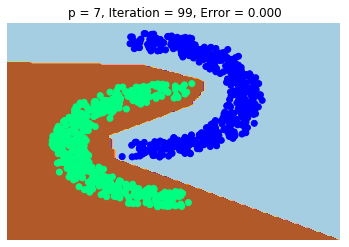

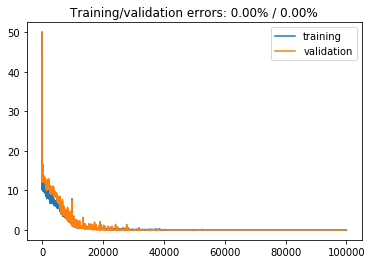

In [0]:
# Run training
h = 7
lrate = .02
tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate)

### :: TASK 1.6 ::

**Random initializations.** Repeat this procedure 5 times from 5 different random initializations. Record for each run the final training and validation errors. Did the network always converge to zero training error? Summarize your final training and validation errors into a table for the 5 runs. You do not need to include the decision hyper-plane visualizations. Note: to speed-up the training you can plot the visualization figures less often (or never) and hence speed-up the training.

In [0]:
nb_measures = 5
last_error_history = np.zeros((nb_measures, 2)) # 1st col: tr, 2nd: val 
for i in range(nb_measures):
  tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never')
  last_error_history[i, 0] = tr_error[-1]
  last_error_history[i, 1] = val_error[-1]

print(last_error_history)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


The network always converges to zero, no matter what the initialization is. Indeed, as the data is not very hard to separate, the loss function is probably quite smooth, and that is why there is no unstability coming from the initialization.

### :: SAMPLE TASK ::

For this task, the answer is given. Run the given code and answer Task 1.8 similarly.

**Learning rate:**

Keep $h=7$ and change the learning rate to values $\text{lrate} = \{2, 0.2, 0.02, 0.002\}$. For each of these values run the training procedure 5 times and observe the training behaviour. You do not need to include the decision hyper-plane visualizations in your answer.

**- Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the learning rate, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**- Make another figure** where *training error evolution* for each learning rate is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

In [0]:
nEpochs = 40
trials = 5
lrates = [2, 0.2, 0.02, 0.002]
plot_data_lr = np.zeros((2, trials, len(lrates), nEpochs*1000))
h = 7
for j, lrate in enumerate(lrates):
    print('LR = %f' % lrate)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_lr[0, i, j, :] = tr_error
        plot_data_lr[1, i, j, :] = val_error

LR = 2.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


LR = 0.200000
LR = 0.020000
LR = 0.002000


Text(0, 0.5, 'training error')

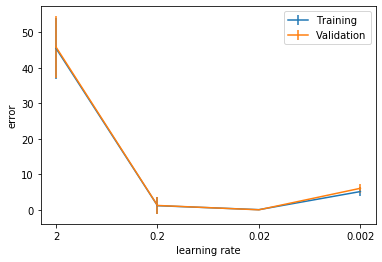

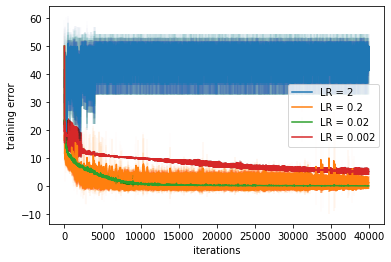

In [0]:
plt.errorbar(np.arange(len(lrates)), plot_data_lr[0, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(lrates)), plot_data_lr[1, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(lrates)), lrates)
plt.xlabel('learning rate')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure()
for j, lrate in enumerate(lrates):
    x = np.arange(plot_data_lr.shape[3])
    # Mean training loss over trials
    y = plot_data_lr[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_lr[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='LR = ' + str(lrate))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

### :: TASK 1.7 ::

**- Briefly discuss** the different behaviour of the training for different learning rates. How many iterations does it take to converge or does it converge at all? Which learning rate is  better and why?

When the learning rate is equal to $0.2$ or $0.02$, it converges. However, when the learning rate is equal to $0.002$ or $2$, it does not converge, for different reasons:

- When the learning rate is too small (e.g. $0.002$), the steps taken at each iteration are too small for the algorithm to converge in $40$ epochs. Adding more epochs would solve the issue, but the best thing to do is to take a greater learning rate.

- When the learning rate is too large (e.g. 2), the steps are too large and the algorithm cannot converge. Indeed, when the algorithm starts getting close to the optimum, it takes a step too large and misses the optimal point. Doing it at every iteration, it keeps having a high error.

Hence, the choice has to be made between $0.2$ and $0.02$. The graph is smoother with the value $0.02$ and converges quickly, hence it is the better learning rate to choose. The variance in the graph with the value $0.2$ may come from the fact that $0.2$ is still a bit too high and we have a similar bevahior than with the value $2$.

### :: TASK 1.8 ::
**The number of hidden units:**

Set the learning rate to 0.02 and change the number of hidden units $h = \{1, 2, 5, 7, 10, 100\}$. For each of these values run the training procedure 5 times and observe the training behaviour

**-Visualize** one decision hyper-plane per number of hidden units.

**-Make one figure** where *final* error for (i) training and (ii) validation sets are superimposed. $x$-axis should be the different values of the number of hidden units, $y$-axis the error *mean* across 5 runs. Show the standard deviation with error bars and make sure to label each plot with a legend.

**-Make another figure** where *training error evolution* for each number of hidden units is superimposed. $x$-axis should be the iteration number, $y$-axis the training error *mean* across 5 runs for a given learning rate. Show the standard deviation with error bars and make sure to label each curve with a legend.

**-Briefly discuss** the different behaviours for the different numbers of hidden units.

In [0]:
nEpochs = 40
trials = 5
hidden_units = [1, 2, 5, 7, 10, 100]
plot_data_hidden = np.zeros((2, trials, len(hidden_units), nEpochs*1000))
lrate = 0.02
for j, h in enumerate(hidden_units):
    print('Hidden units = %f' % h)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_hidden[0, i, j, :] = tr_error
        plot_data_hidden[1, i, j, :] = val_error

Hidden units = 1.000000
Hidden units = 2.000000
Hidden units = 5.000000
Hidden units = 7.000000
Hidden units = 10.000000
Hidden units = 100.000000


Text(0, 0.5, 'training error')

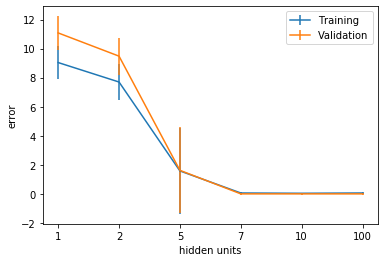

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


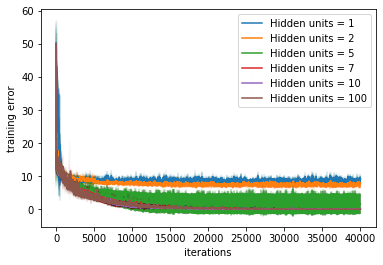

In [0]:
plt.errorbar(np.arange(len(hidden_units)), plot_data_hidden[0, :, :, -1].mean(axis=0), yerr=plot_data_hidden[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(hidden_units)), plot_data_hidden[1, :, :, -1].mean(axis=0), yerr=plot_data_hidden[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(hidden_units)), hidden_units)
plt.xlabel('hidden units')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each number of hidden units
plt.figure()
for j, h in enumerate(hidden_units):
    x = np.arange(plot_data_hidden.shape[3])
    # Mean training loss over trials
    y = plot_data_hidden[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_hidden[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='Hidden units = ' + str(h))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

We see that when the number of hidden units is too small (e.g. $1$ or $2$), the training error does not converge to $0$. This is due to an underfitting. Indeed, as the number of hidden units is too small, the neural network cannot learn the structure of the data, which is too complex. Hence, when it is trained, it cannot generalize well and that is why the validation error is higher than the training error for $h = 1, 2$.

When the number of hidden units is higher, we see that it converges.

# Part 2 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).


## Install PyTorch

In [0]:
!pip install torch torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.3.0+cu100
True


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions 
$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$
Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$. 

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional *lattice* is a discrete grid embedded in $R^2$, similar for example to a checkerboard.

(384, 512, 3)


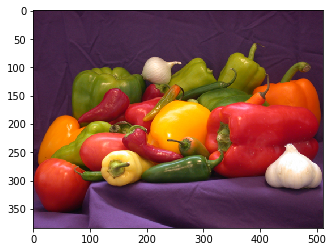

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision

# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/peppers.png
# Read the image 
x = np.asarray(Image.open('peppers.png'))/255.0
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print(x.shape)
# Visualize the input x
plt.imshow(x)
# Convert to torch tensor
x = torch.from_numpy(x).permute(2, 0, 1).float()
# Prepare it as a batch
x = x.unsqueeze(0)

This should display an image of bell peppers.

Next, we create a convolutional layer with a bank of 10 filters of dimension $5 \times 5 \times 3$ whose coefficients are initialized randomly. This uses the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) module from PyTorch:

In [0]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())

torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.

In [0]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:

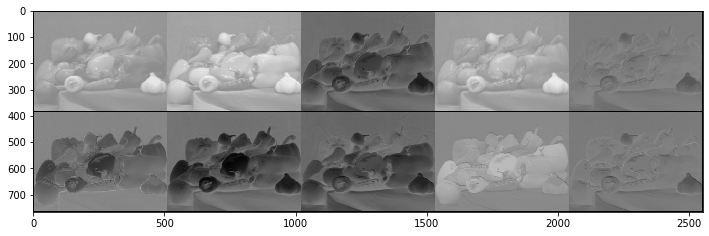

In [0]:
# Visualize the output y
def vis_features(y):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(out.size())
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Show
    plt.imshow(out)
    # Remove grid
    plt.gca().grid(False)

plt.figure(figsize=(12, 12))
vis_features(y)

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


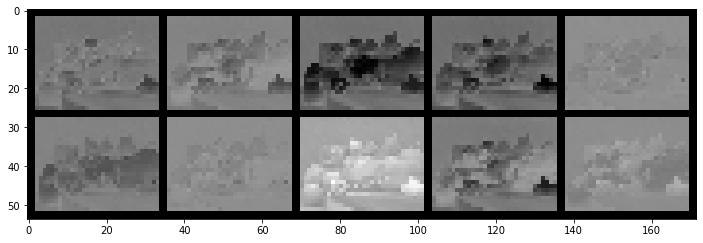

In [0]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
plt.figure(figsize=(12, 12))
vis_features(y_ds)

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


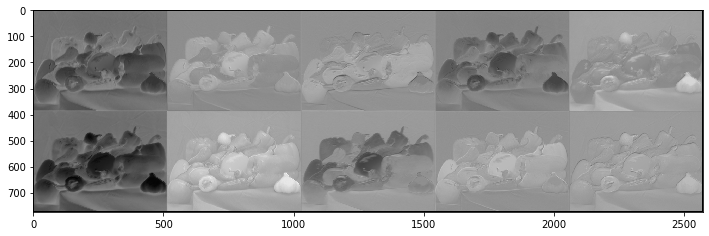

In [0]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
plt.figure(figsize=(12, 12))
vis_features(y_pad)

In order to consolidate what has been learned so far, we will now design a filter by hand:


torch.Size([1, 3, 384, 512])
torch.Size([1, 1, 384, 512])


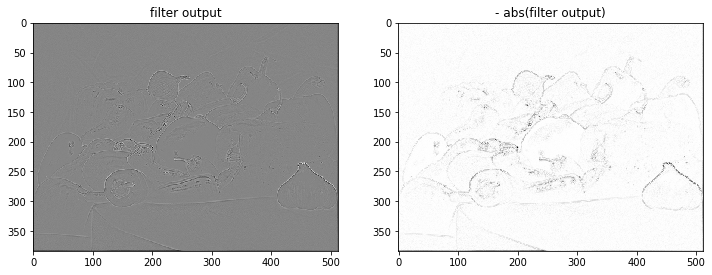

In [0]:
w = torch.FloatTensor([[0,  1, 0 ],
                      [1, -4, 1 ],
                      [0,  1, 0 ]])
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w)
y_lap = conv_lap(x)
print(x.size())
print(y_lap.size())

plt.figure(figsize=(12, 12))
plt.subplot(121)
vis_features(y_lap)
plt.title('filter output')

plt.subplot(122)
vis_features(-torch.abs(y_lap))
plt.title('- abs(filter output)') ;


### :: TASK 2.1 ::
* i. What filter have we implemented?
* ii. How are the RGB colour channels processed by this filter?
* iii. What image structure are detected?

i. We have implemented a filter that computes the Laplacian of the image $I$. Indeed, in $(x, y)$, the image obtained from the filtering of $I$ by $w$ (the filter defined in the previous code cell), has the value:

\begin{equation}
\small
I \star w (x, y) = I(x-1, y) + I(x+1, y) + I(x, y-1) + I(x, y+1) - 4 I(x, y)
\end{equation}

Using a second order Taylor expansion, between $(x-1, y)$ and $(x, y)$ and between $(x+1, y)$ and $(x, y)$, we have:

\begin{equation}
\small
I(x-1, y) \approx I(x, y) - \frac{\partial I}{\partial x}(x, y) + \frac{1}{2} \frac{\partial^{2} I}{\partial x^{2}}(x, y) \\
\small
I(x+1, y) \approx I(x, y) + \frac{\partial I}{\partial x}(x, y) + \frac{1}{2} \frac{\partial^{2} I}{\partial x^{2}}(x, y)
\end{equation}

Hence, the sum gives:

\begin{equation}
\small
I(x-1, y) + I(x+1, y) \approx 2 I(x, y) + \frac{\partial^{2} I}{\partial x^{2}}(x, y)
\end{equation}

Similarly,

\begin{equation}
\small
I(x, y-1) + I(x, y+1) \approx 2 I(x, y) + \frac{\partial^{2} I}{\partial y^{2}}(x, y)
\end{equation}

Finally, we get, by summing the two above equations:

\begin{equation}
\small
I(x-1, y) + I(x+1, y) + I(x, y-1) + I(x, y+1) - 4 I(x, y) \approx \frac{\partial^{2} I}{\partial x^{2}}(x, y) + \frac{\partial^{2} I}{\partial y^{2}}(x, y)
\end{equation}

i.e.

\begin{equation}
\boxed{I \star w (x, y) \approx \frac{\partial^{2} I}{\partial x^{2}}(x, y) + \frac{\partial^{2} I}{\partial y^{2}}(x, y)}
\end{equation}

ii. The filter is applied to each channel independently and the results are added together.

iii. This filter can detect edges.


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*
$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$
This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). Run the code below and understand what the filter $\mathbf{w}$ is doing.


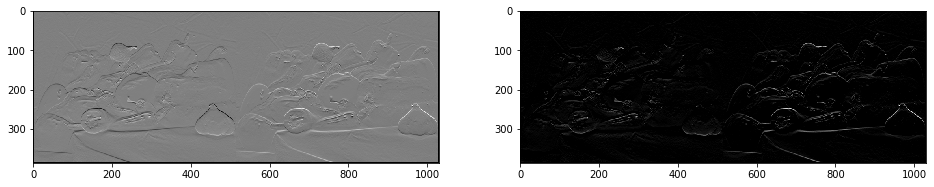

In [0]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

plt.figure(figsize=(16, 18))
plt.subplot(121)
vis_features(y)
plt.subplot(122)
vis_features(z)

## Pooling
There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:
$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$
Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

### :: TASK 2.2 ::

Run the code below to try max-pooling. Look at the resulting image. Can you interpret the result?

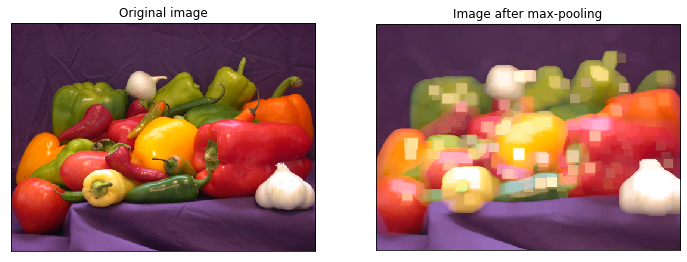

In [0]:
mp = torch.nn.MaxPool2d(15, stride=1)
y = mp(x)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title('Original image')
plt.xticks(())
plt.yticks(())
plt.imshow(x.squeeze().permute(1, 2, 0).numpy())  # original image

plt.subplot(122)
plt.title('Image after max-pooling')
plt.xticks(())
plt.yticks(())
plt.imshow(y.squeeze().permute(1, 2, 0).numpy())  # image after max-pooling
plt.gca().grid(False)

In the uniform zones, there is no big change. On the edges, we see that the brightest zone is expanded over the darkest zone. This is because of the `max` operation. If we consider a pixel close to an edge and a $14 \times 14$ window centered in this pixel, then the pixel will take the maximum value in the window. Hence, if a pixel close to an edge belongs to the darkest of the two zones, it will become brighter because of the zone on the other side. That's why the bright reflections on the fruits become bigger.

# Part 3 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.

## Imports

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

## Parameters

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

In [0]:
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

## Warmup





It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

In [0]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the dataset from the internet
dataset = 'cifar10'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### :: TASK 3.1 ::

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images. Display 5 images from the dataset together with their category label. [See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

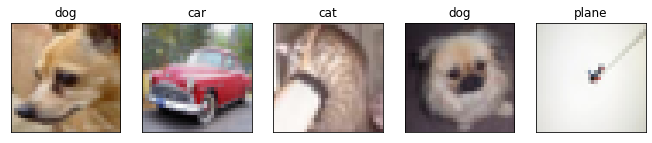

In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_images(images, titles, n_row=3, n_col=4):
    '''Helper function to plot some images and their labels'''

    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

    for i in range(n_row * n_col):
      norm_img = images[i].permute(1, 2, 0)
      unnorm_img = norm_img / 2 + .5
      plt.subplot(n_row, n_col, i + 1)
      plt.imshow(unnorm_img)
      plt.title(classes[titles[i]], size=12)
      plt.xticks(())
      plt.yticks(())

# get some random training images
train_iter = iter(train_loader)
images, labels = train_iter.next()

# show images
plot_images(images[:5], labels[:5], n_row=1, n_col=5)


## Training a Convolutional Network on CIFAR-10




Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.

In [0]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
# Single layer network architecture

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs
        
    def forward(self, input):
        input = input.view(-1, self.num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [0]:
# Train
network = Net(3072, 10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.377005
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.768366
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.800020
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.852718
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.765571
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.760136
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.954183
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.805387


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
170500096it [00:29, 18414445.78it/s]                               


Test set: Average loss: 1.8009, Accuracy: 19101/50000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.818821
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.676602
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.715313
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.609640
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.650947
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.935599
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.682122
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.889482

Test set: Average loss: 1.7356, Accuracy: 20434/50000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.906941
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.951823
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.642059
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.813610
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.639211
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.805981
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.512208
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.560925

Test set: Average loss: 1.7115, Accuracy: 20891/50000 (42%)

Train Epoch: 4 [0/50000 (0

### :: TASK 3.2 ::

Add code to create a convolutional network architecture as below.

  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

In [0]:
class ConvNet(nn.Module):
  '''
  CNN architecture with two convolutional layers and two fully connected layers.
  '''
  def __init__(self, n_channels):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=5, padding=1, bias=False)
    self.conv2 = nn.Conv2d(16, 128, kernel_size=5, padding=1, bias=False)
    self.fc1 = nn.Linear(6 * 6 * 128, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.max_pool2d(torch.tanh(self.conv1(x)), kernel_size=2)
    x = F.max_pool2d(torch.tanh(self.conv2(x)), kernel_size=2)
    x = x.view(-1, self.num_flat_features(x))
    x = torch.tanh(self.fc1(x))
    x = self.fc2(x)
    return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

### :: TASK 3.3 ::

Some of the functions in a CNN must be non-linear. Why?





If the functions in a CNN are linear, i.e. if for $i = 1, \dots, L$, we have $f_i(\mathbf{x};\mathbf{w}_i) = \mathbf{w}_i\mathbf{x}$, then

\begin{equation}
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L})
\end{equation}

becomes

\begin{equation}
f(\mathbf{x}) = \underbrace{\mathbf{w}_L \dots \mathbf{w}_1}_{\mathbf{W}} \mathbf{x} = \mathbf{Wx}
\end{equation}

and the CNN boils down to a simple linear function. Hence, the functions in a CNN must be non-linear.

### :: TASK 3.4 ::
Train the CNN for 20 epochs on the CIFAR-10 training set.



In [0]:
# Train
network=ConvNet(3)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 21):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303725
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.166328
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.068880
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.854425
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.866403
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.843989
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.748871
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.681126


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.7757, Accuracy: 3822/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.840384
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.602924
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.590024
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.896803
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.618719
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.555208
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.630384
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.782557

Test set: Average loss: 1.6113, Accuracy: 4328/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.662788
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.557756
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.569440
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.663673
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.495645
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.542535
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.732092
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.506104

Test set: Average loss: 1.4886, Accuracy: 4769/10000 (48%)

Train Epoch: 4 [0/50000 (0%)]

### :: TASK 3.5 ::
Plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )


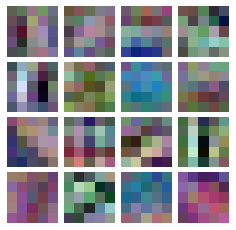

In [0]:
def plot_kernels(tensor, num_cols=4):
  '''See thread #1 in the task description for the source.'''
  
  if not tensor.ndim==4:
    raise Exception("assumes a 4D tensor")
  if not tensor.shape[-1]==3:
    raise Exception("last dim needs to be 3 to plot")
  num_kernels = tensor.shape[0]
  num_rows = 1 + num_kernels // num_cols
  fig = plt.figure(figsize=(num_cols,num_rows))
  for i in range(tensor.shape[0]):
      ax1 = fig.add_subplot(num_rows,num_cols,i+1)
      ax1.imshow(tensor[i])
      ax1.axis('off')
      ax1.set_xticklabels([])
      ax1.set_yticklabels([])

  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
filters = network.modules
layer1 = [i for i in network.children()][0] # first layer, it is a conv2d
tensor = layer1.weight.data.permute(0, 2, 3, 1).numpy()
plot_kernels((tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor)))

### :: TASK 3.6 :: 

What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?

The model has $4$ layers:
* A convolutional layer with $3$ input channels, $16$ output channels and $5 \times 5$ filters, and there is no bias. Hence, the dimensionnality of the weights is $16 \times 3 \times 5 \times 5$. In total, there are $1\,200$ parameters.

* Similarly, in the second convolutional layer, there are $128 \times 16 \times 5 \times 5$ parameters, i.e. $51\,200$ parameters.

* The third layer is a fully connected layer with $6 \times 6 \times 128 = 4\,608$ inputs and $64$ outputs. Hence, the matrix of weights of this layer is in $\mathbb{R}^{64 \times 4\,608}$. There is also a bias with $64$ parameters. Thus, it has $294\,976$ parameters.

* The last layer is a fully connected layer with $64$ inputs and $10$ outputs. There is a bias with $10$ parameters. Hence, this layer has $650$ parameters.

In total, there are $348\,026$ parameters in this CNN architecture.



## Useful resources

  - [PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)
  - [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

Antoine Moulin